# Fake News Detection

This Project is related to detecting whether the news are real (0) or fake (1) using recurrent neural network

Dataset: 

## Importing necessary libraries and dataset

In [1]:
import nltk
nltk.download('punkt')
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Piotrek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Reading dataset
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

## Exploring dataset


In [3]:
df_true.info()
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [4]:
df_true.describe()


title  \
count                                               21417   
unique                                              20826   
top     Factbox: Trump fills top jobs for his administ...   
freq                                                   14   

                                                     text       subject  \
count                                               21417         21417   
unique                                              21192             2   
top     (Reuters) - Highlights for U.S. President Dona...  politicsNews   
freq                                                    8         11272   

                      date  
count                21417  
unique                 716  
top     December 20, 2017   
freq                   182

In [5]:
df_fake.describe()

title   text subject  \
count                                               23481  23481   23481   
unique                                              17903  17455       6   
top     MEDIA IGNORES Time That Bill Clinton FIRED His...           News   
freq                                                    6    626    9050   

                date  
count          23481  
unique          1681  
top     May 10, 2017  
freq              46

In [6]:
df_true.isnull().sum()


title      0
text       0
subject    0
date       0
dtype: int64

In [7]:
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

## Feature engineering

In [8]:
df_true['isFake'] = 0
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isFake  
0  December 31, 2017        0  
1  December 29, 2017        0  
2  December 31, 2017        0  
3  December 30, 2017        0  
4  December 29, 2017        0

In [9]:
df_fake['isFake'] = 1
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  isFake  
0  December 31, 2017       1  
1  December 31, 2017       1  
2  December 30, 2017       1  
3  December 29, 2017       1  
4  December 25, 2017       1

In [10]:
# Combining both dataset
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isFake  
0      December 31, 2017        0  
1      December 29, 2017        0  
2      December 31, 2017        0  
3      December 30, 2017        0  
4      December 29, 2017        0  
...                   ...     ...  
44893    January 16, 2016       1  
44894    January 16, 2016       1  
44895    January 15, 2016       1  
44896    January 14, 2016       1  
44897    January 12, 2016       1  

[44898 rows x 5 columns]

In [11]:
df.drop(columns = ['date'], inplace=True)

In [12]:
# combining title and text
df['original'] = df['title'] + ' ' + df['text']
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isFake                                           original  
0           0  As U.S. budget fight looms, Republicans flip t...  
1           0  U.S. military to accept transgender recruits o...  
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...  
3           0  FBI Russia probe helped by Australian diplomat...  
4           0  Trump wants Postal Service to charge 'much mor...  
...       ...                                                ...  
44893       1  McPain: John McCain Furious That Iran Treated ...  
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  
44896       1  How to Blow $700 Million: Al Jazeera America F...  
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...  

[44898 rows x 5 columns]

## Data Cleaning

In [13]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Piotrek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Obtaining stopwords from nltk
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use'])

In [15]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [16]:
# Removing stopwords from the dataset
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [17]:
df['clean'] = df['original'].apply(preprocess)

In [18]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [19]:
df['clean'][0]

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [20]:
# Obtaiining the total words present in the dataset
list_of_words = []
for row in df.clean:
    for word in row:
        list_of_words.append(word)

In [21]:
df.clean[0][0]

'budget'

In [22]:
len(list_of_words)

9276947

In [23]:
# Obtaining the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [24]:
# Combining all words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df.clean_joined

0        budget fight looms republicans flip fiscal scr...
1        military accept transgender recruits monday pe...
2        senior republican senator mueller washington r...
3        russia probe helped australian diplomat washin...
4        trump wants postal service charge amazon shipm...
                               ...                        
44893    mcpain john mccain furious iran treated sailor...
44894    justice yahoo settles mail privacy class actio...
44895    sunnistan allied safe zone plan territorial bo...
44896    blow million jazeera america finally calls qui...
44897    navy sailors held iranian military signs neoco...
Name: clean_joined, Length: 44898, dtype: object

# Visualizaing dataset

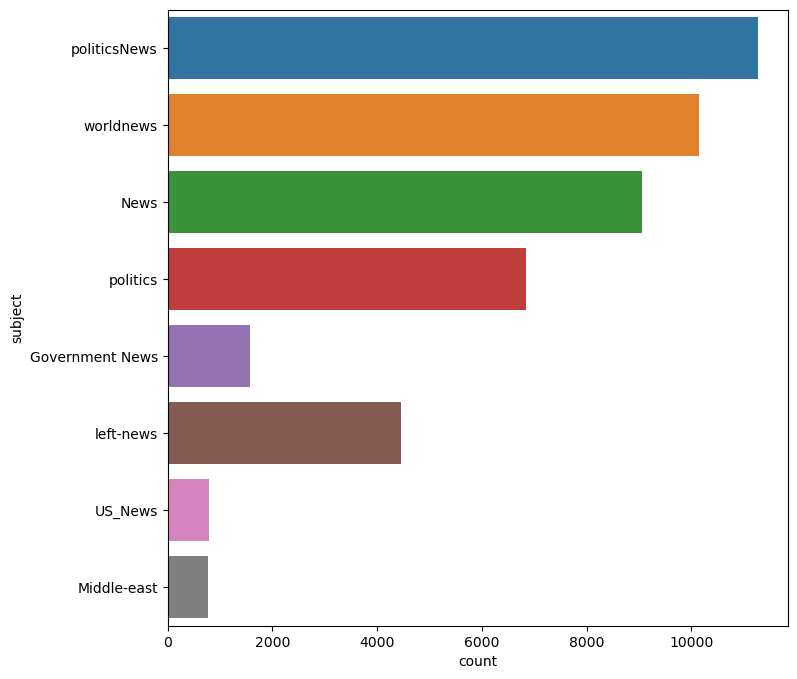

In [25]:
# Plotting the number of sample in 'subject'
plt.figure(figsize= (8,8))
sns.countplot( y = 'subject', data = df)
plt.show()

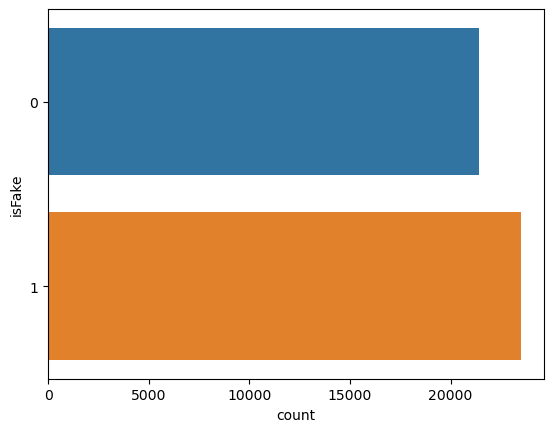

In [26]:
sns.countplot(y = 'isFake',data = df)
plt.show()

In [27]:
# plotting the word cloud for text that is fake
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df[df.isFake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')


In [28]:
# plotting the word cloud for text that is real
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df[df.isFake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

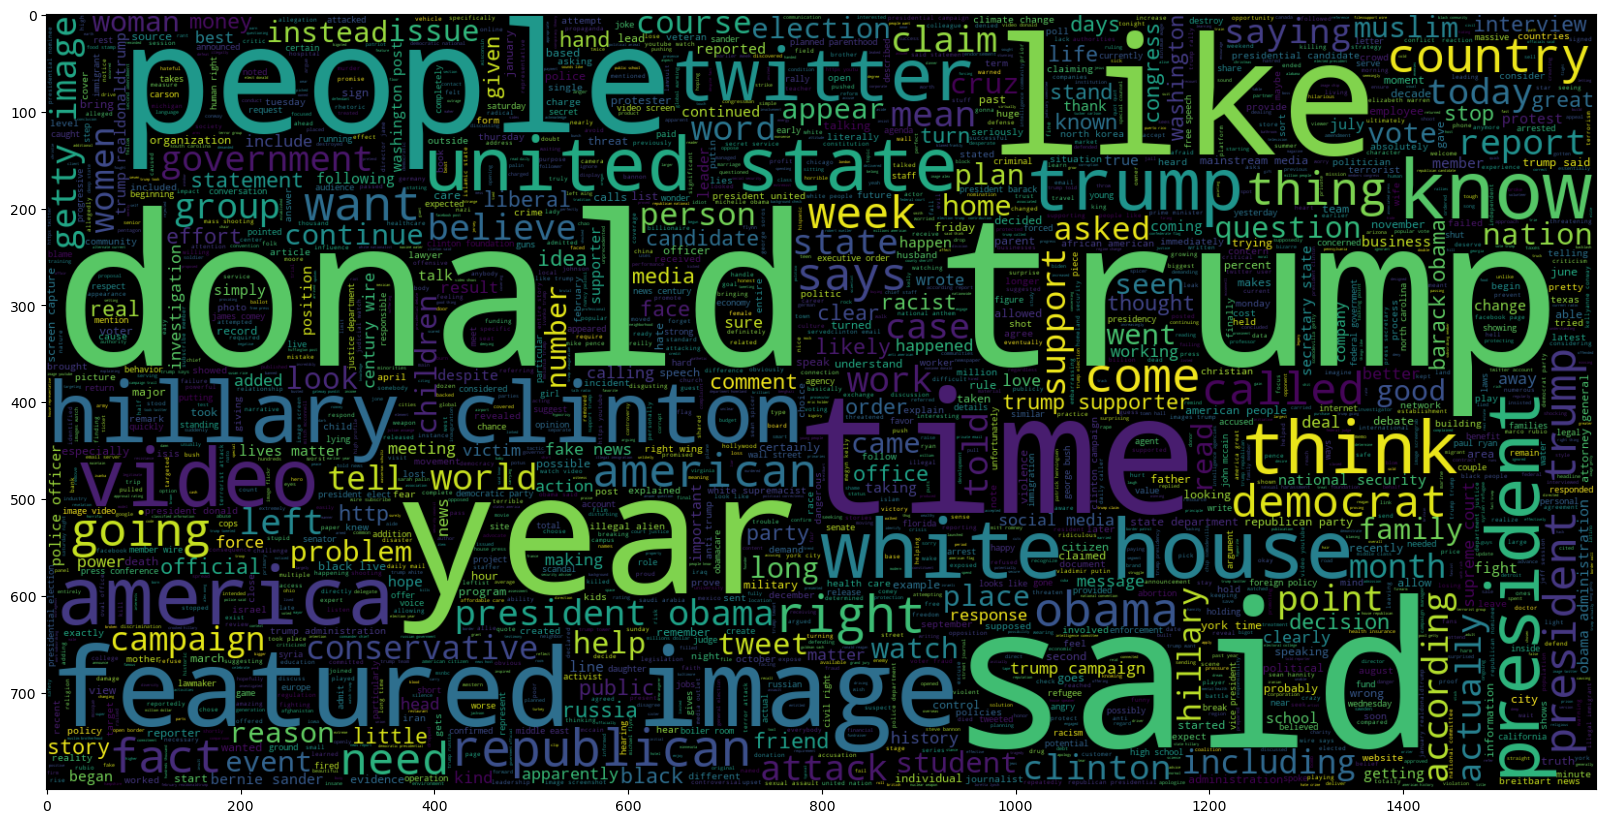

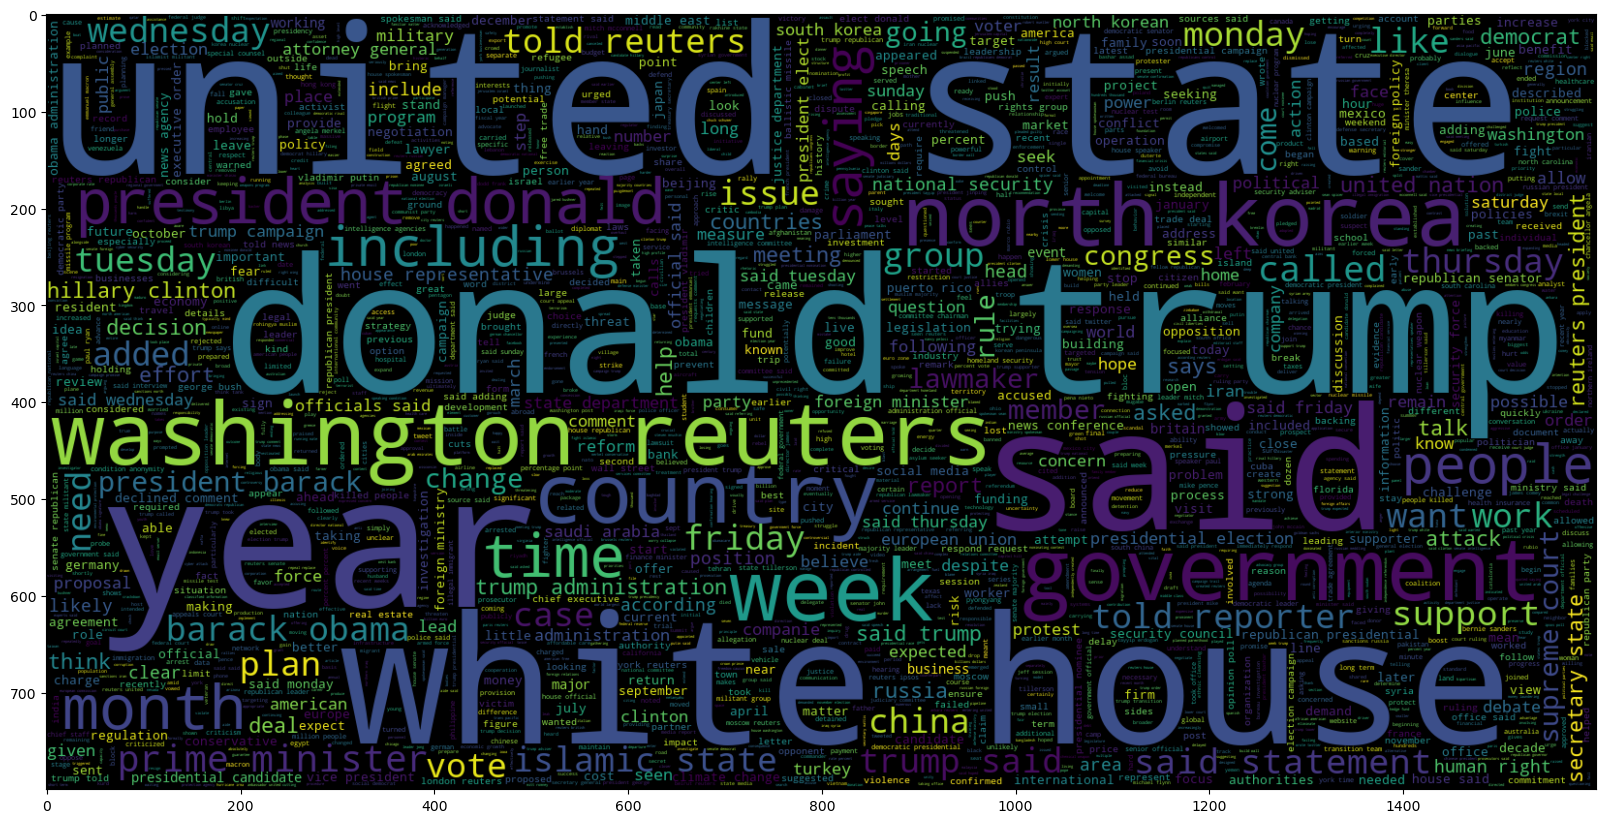

In [29]:
plt.show()

In [30]:
# Getting the longest row
maxlen = -1
for row in df.clean_joined:
    tokens = nltk.word_tokenize(row)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)

print("The maximum number of words in a row is: ", maxlen)

The maximum number of words in a row is:  4405


In [31]:
# Visualizing the distribution of number of words in a text 
import plotly.express as px
fig = px.histogram( x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

## Tokenization and Padding

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isFake, test_size=0.2)

In [33]:
# Creating a tokenizer
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [34]:
# Adding padding
padded_train = pad_sequences(train_sequences, maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 40, truncating = 'post')

## Building and training network

In [35]:
model = Sequential()

model.add(Embedding(total_words,output_dim = 128))
model.add(Bidirectional(LSTM(128)))

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss= "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13914112  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,210,305
Trainable params: 14,210,305
Non-trainable params: 0
_________________________________________________________________


In [36]:
y_train = np.asarray(y_train)

In [37]:
y_train

array([1, 0, 0, ..., 1, 0, 1], dtype=int64)

In [39]:
model.fit(padded_train, y_train, batch_size=64, validation_split=0.1, epochs = 5 )

Epoch 1/5
506/506 [==============================] - 103s 203ms/step - loss: 0.0108 - accuracy: 0.9972 - val_loss: 0.0047 - val_accuracy: 0.9986
Epoch 2/5
506/506 [==============================] - 118s 233ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0046 - val_accuracy: 0.9992
Epoch 3/5
506/506 [==============================] - 114s 225ms/step - loss: 4.8933e-04 - accuracy: 0.9999 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 4/5
506/506 [==============================] - 120s 237ms/step - loss: 1.3101e-04 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9992
Epoch 5/5
506/506 [==============================] - 124s 245ms/step - loss: 4.4222e-06 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9992


In [40]:
pred = model.predict(padded_test)

281/281 [==============================] - 4s 13ms/step


In [41]:
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [42]:
# Getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy: ", accuracy)


Model accuracy:  0.9612472160356348


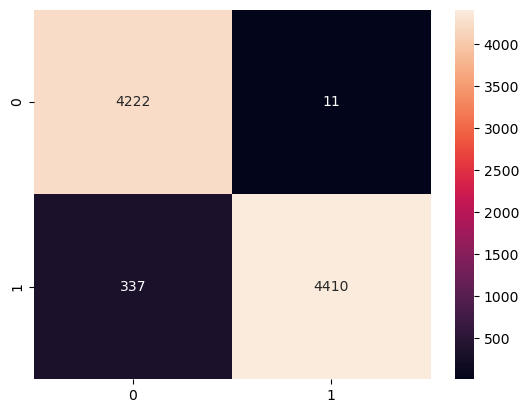

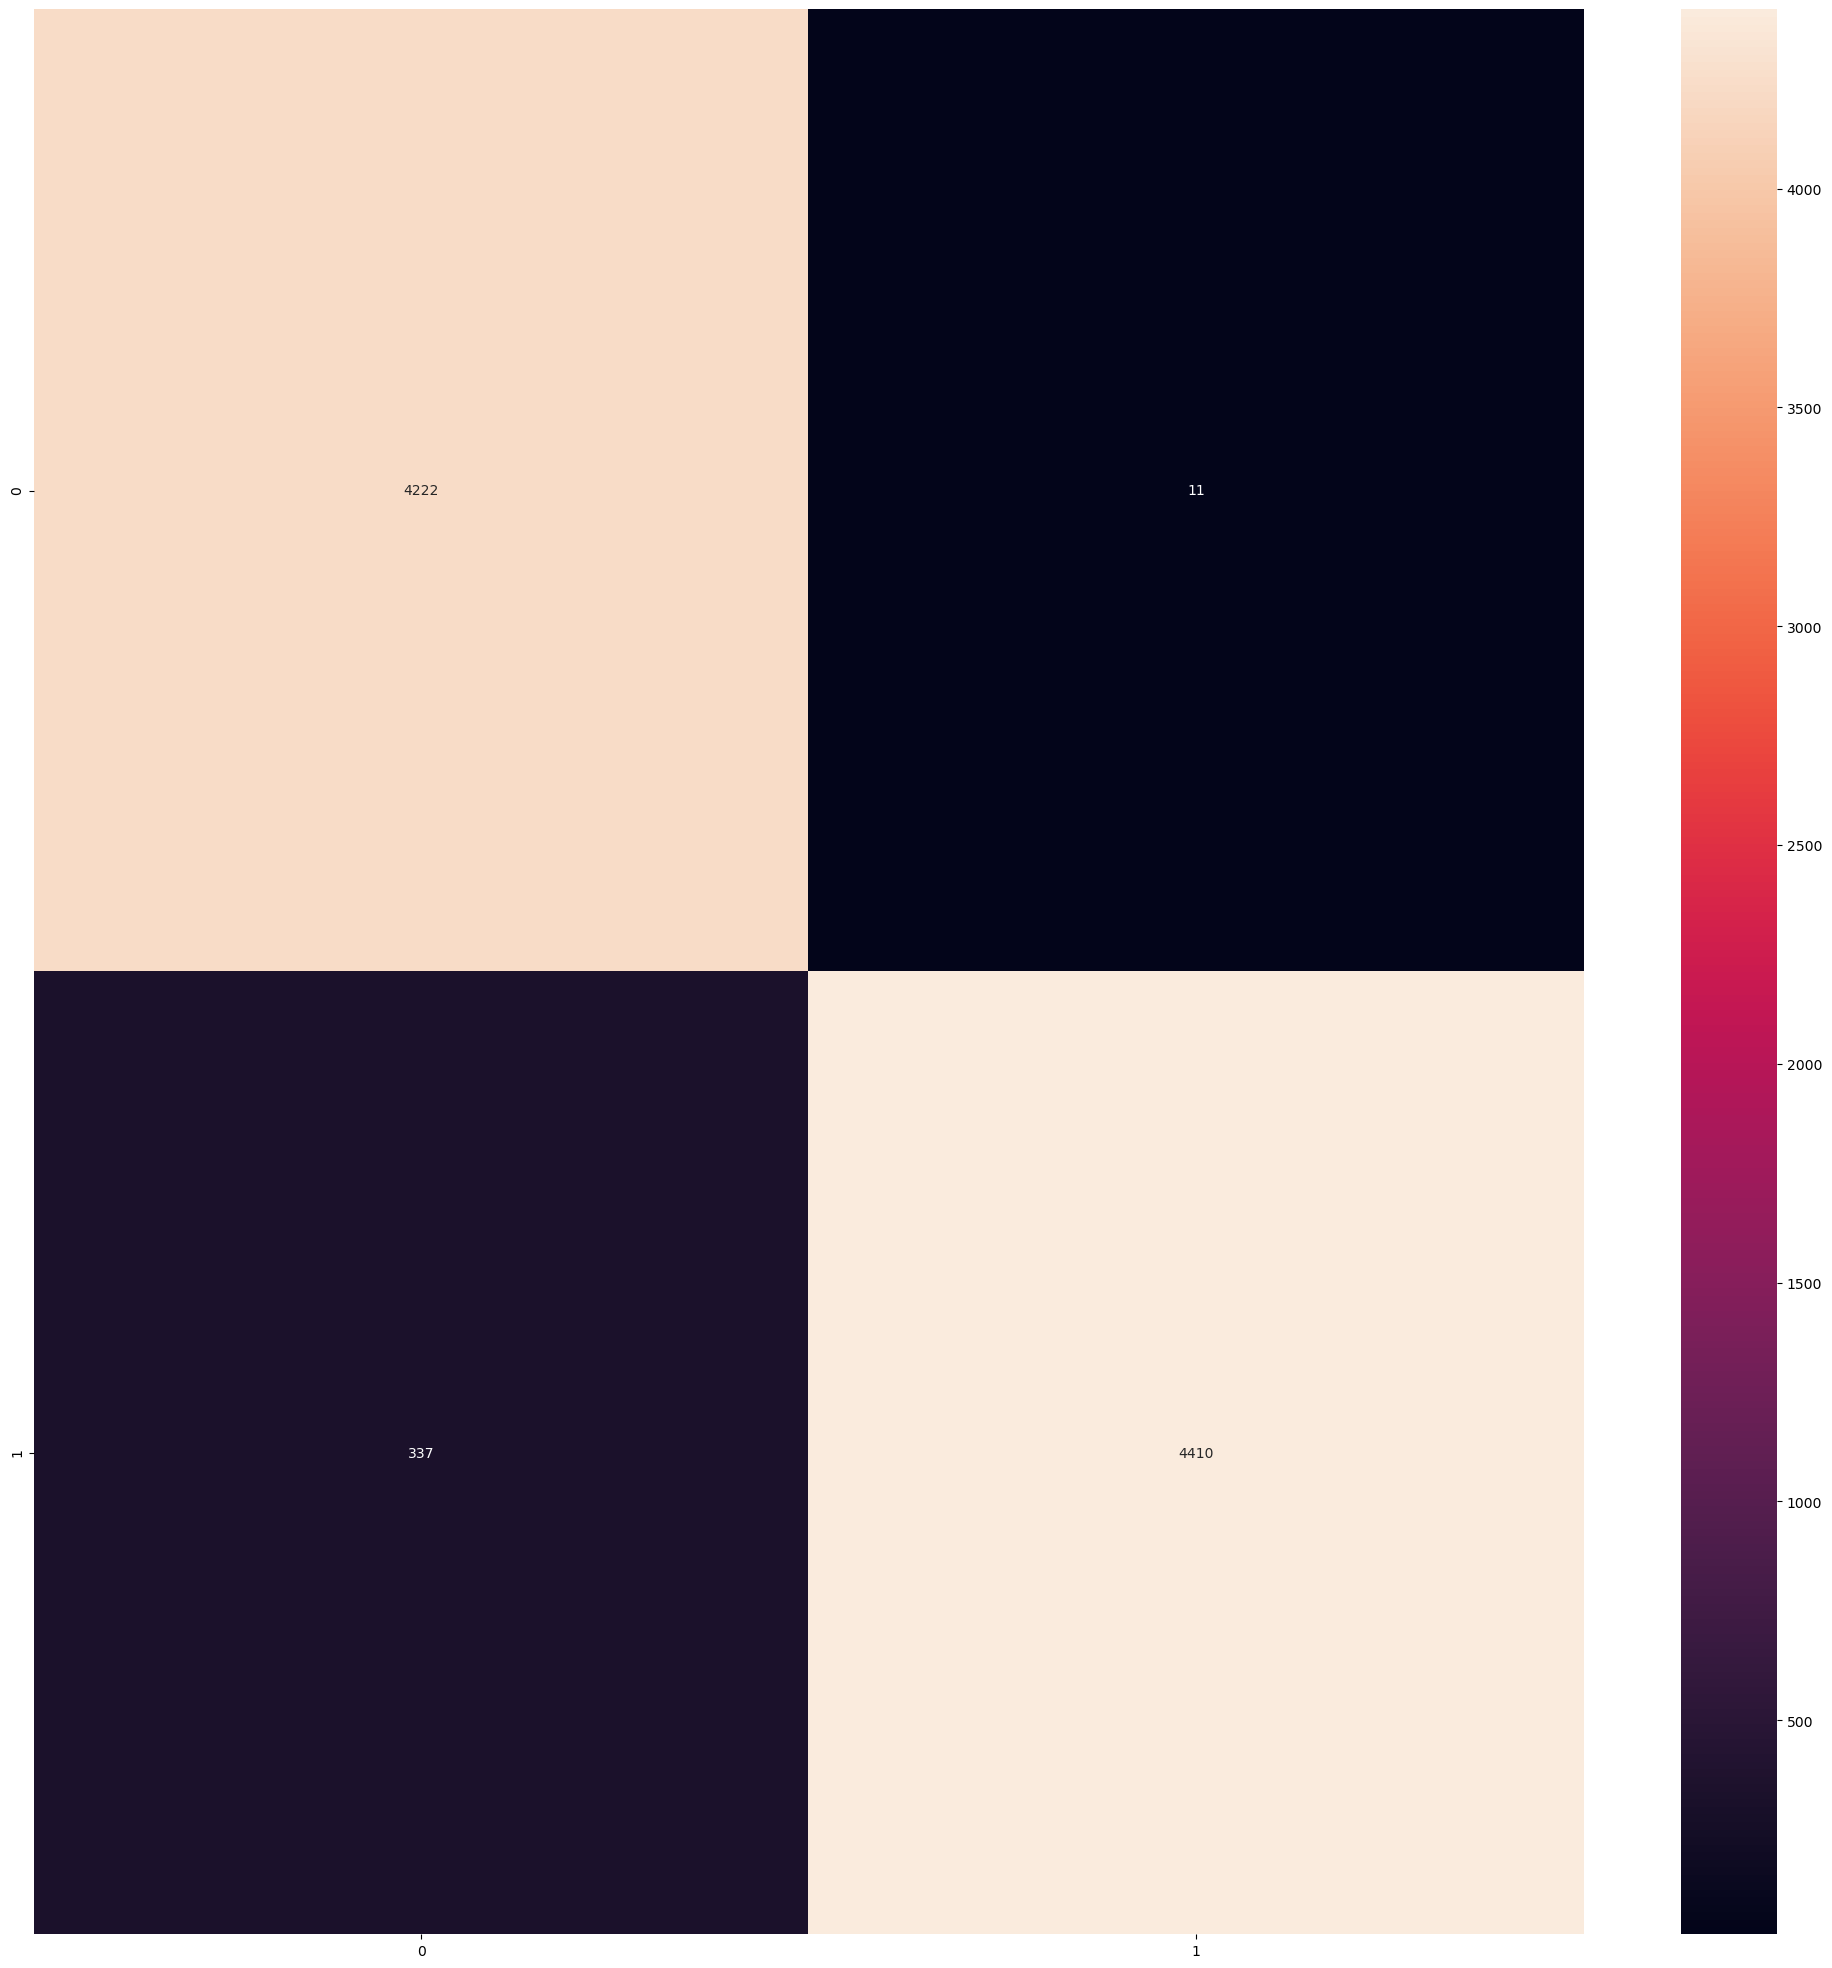

<Figure size 2500x2500 with 0 Axes>

In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
sns.heatmap(cm, annot= True, fmt='d')
plt.figure(figsize = (25, 25))
plt.show()
